In [2]:
import os
import numpy as np

In [3]:
try:
    base_dir = './dataset/'
    train_dir = os.path.join(base_dir,'train')
    preview_dir = os.path.join(base_dir,'preview')
    validation_dir = os.path.join(base_dir,'validation')
    test_dir = os.path.join(base_dir,'test')
    
    train_fbanana_dir = os.path.join(train_dir,'freshbanana')
    train_foranges_dir = os.path.join(train_dir,'freshoranges')
    train_roranges_dir = os.path.join(train_dir,'rottenoranges')
    train_rbanana_dir = os.path.join(train_dir,'rottenbanana')
    
    val_fbanana_dir = os.path.join(validation_dir,'freshbanana')
    val_rbanana_dir = os.path.join(validation_dir,'rottenbanana')
    val_foranges_dir = os.path.join(validation_dir,'freshoranges')
    val_roranges_dir = os.path.join(validation_dir,'rottenoranges')
    
    test_fresh_bananas_dir = os.path.join(test_dir, 'freshbanana')
    test_fresh_oranges_dir = os.path.join(test_dir, 'freshoranges')
    test_rotten_bananas_dir = os.path.join(test_dir, 'rottenbanana')
    test_rotten_oranges_dir = os.path.join(test_dir, 'rottenoranges')
    
    print('total fresh training banana images: ',len(os.listdir(train_fbanana_dir)))
    print('total fresh training oranges images: ',len(os.listdir(train_foranges_dir)))
    print('total rotten training oranges images: ',len(os.listdir(train_roranges_dir)))
    print('total rotten banana oranges images: ',len(os.listdir(train_rbanana_dir)))
    print('total val fresh banana images: ',len(os.listdir(val_fbanana_dir)))
    print('total val fresh oranges images: ',len(os.listdir(val_foranges_dir)))
    print('total val rotten oranges images: ',len(os.listdir(val_roranges_dir)))
    print('total val rotten banana images: ',len(os.listdir(val_rbanana_dir)))
    

except OSError:
    pass

total fresh training banana images:  1581
total fresh training oranges images:  1466
total rotten training oranges images:  1595
total rotten banana oranges images:  2224
total val fresh banana images:  381
total val fresh oranges images:  388
total val rotten oranges images:  241
total val rotten banana images:  530


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    width_shift_range=0.2, #0.2, 0.5
    height_shift_range=0.2, #0.2, 0.5
    shear_range=0.2,
    zoom_range=[0.5, 1.0], # 0.2, 0.5, [0.5,1.0]
    rotation_range=90, #20, 40, 60, 90
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect' #nearest, reflect, wrap
)

validation_datagen = ImageDataGenerator(
    rescale=1./255
)

In [6]:
from keras.preprocessing import image
import matplotlib.pyplot as plt

<ipython-input-31-b71a2d9af842>:16: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot((len(preview_img)/4)+1, 4, n+1)


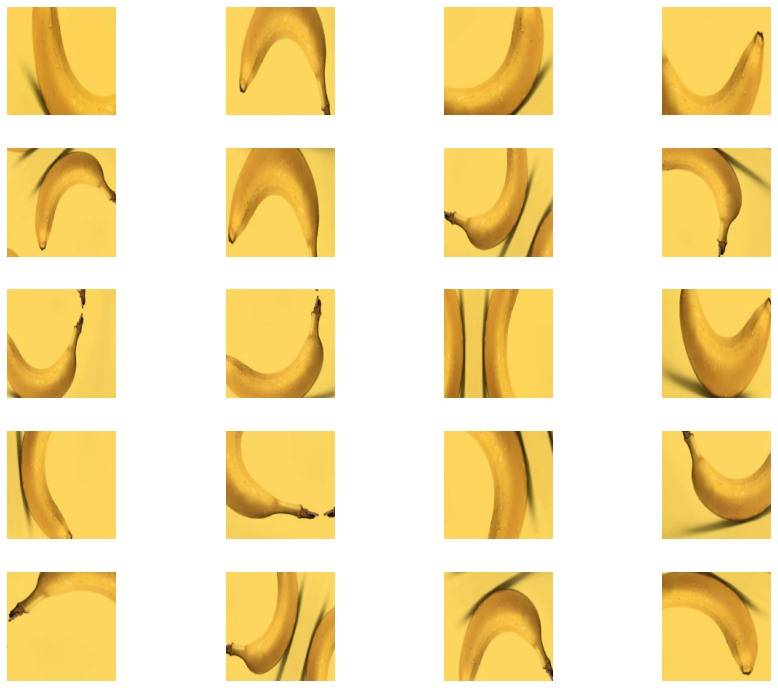

In [31]:
path_aug = os.path.join(train_fbanana_dir, os.listdir(train_fbanana_dir)[-1])
img_augmentation = image.load_img(path_aug)
x_aug = image.img_to_array(img_augmentation)
x_aug = x_aug.reshape((1,) + x_aug.shape)

i = 0
for batch in train_datagen.flow(x_aug, batch_size=1, save_to_dir=preview_dir, save_prefix='fruit', save_format='jpeg'):
    i += 1
    if i >= 20:
        break

preview_img = os.listdir(preview_dir)

plt.figure(figsize=(15, 15))
for n in range(len(preview_img)):
  plt.subplot((len(preview_img)/4)+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image.load_img(os.path.join(preview_dir, preview_img[n]),
                            color_mode="rgb",
                            target_size=(150, 150),
                            interpolation="nearest"))
  plt.axis('off')
plt.show()

for fn in preview_img:
  os.system(f'rm {os.path.join(preview_dir, fn)}')

<h3>Image Generator<h3>

In [7]:
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=32,
                                                    color_mode="rgb",
                                                    # shuffle = False,
                                                    target_size=(150,150), #?
                                                    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         batch_size=32,
                                                         color_mode="rgb",
                                                         # shuffle = False,
                                                         target_size=(150,150), #?
                                                         class_mode='categorical')

Found 6866 images belonging to 4 classes.
Found 1540 images belonging to 4 classes.


In [8]:
import tensorflow as tf

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.98):
      print("\nReached 98% accuracy. Stop Training")
      self.model.stop_training = True

callbacks = myCallback()

<h4>Sequential Model<h4>

In [10]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(4, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 36992)             0

In [11]:
train_len = 0
for foldername in os.listdir('./dataset/train'):
    train_len = train_len + len(os.listdir(os.path.join('./dataset/train',foldername)))
    
val_len = 0
for foldername in os.listdir('./dataset/validation'):
    val_len = val_len + len(os.listdir(os.path.join('./dataset/validation',foldername)))

print(train_len)
print(val_len)

6866
1540


In [12]:
history = model.fit(
    train_generator,
    steps_per_epoch=(train_len/32),
    epochs=3,
    verbose=1,
    callbacks=[callbacks],
    validation_data=validation_generator,
    validation_steps=(val_len/32)
)

Epoch 1/3
215/214 [==============================] - 139s 645ms/step - loss: 0.7774 - accuracy: 0.7142 - val_loss: 0.3864 - val_accuracy: 0.8461
Epoch 2/3
215/214 [==============================] - 144s 668ms/step - loss: 0.3814 - accuracy: 0.8657 - val_loss: 0.2378 - val_accuracy: 0.9318
Epoch 3/3
215/214 [==============================] - 143s 665ms/step - loss: 0.2880 - accuracy: 0.8959 - val_loss: 0.3979 - val_accuracy: 0.8266


### Plot Loss and Accuracy

<Figure size 432x288 with 0 Axes>

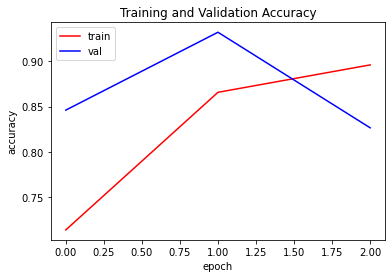

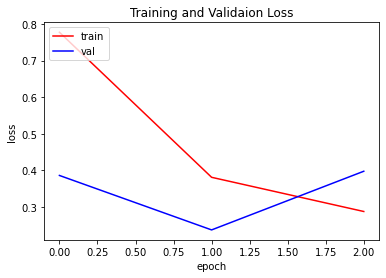

<Figure size 432x288 with 0 Axes>

In [14]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.figure()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.figure()

### Evaluate Model

In [16]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(validation_dir,
                                                  batch_size=1,
                                                  target_size=(150, 150),
                                                  shuffle = False,
                                                  class_mode='categorical')

filenames = test_generator.filenames
nb_samples = len(filenames)

loss, acc = model.evaluate(test_generator,steps = (nb_samples), verbose=1)
print('accuracy test: ',acc)

Found 1540 images belonging to 4 classes.
1540/1540 [==============================] - 16s 11ms/step - loss: 0.3475 - accuracy: 0.8675
accuracy test:  0.86753249168396


In [21]:
model.save('model.h5')

The test_image is classified as [0. 0. 0. 1.]
The key and value associated are: 0=Fresh, 1=Rotten


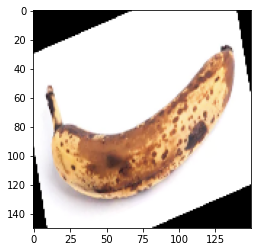

In [88]:
from keras.preprocessing import image
cnn_model = tf.keras.models.load_model('model.h5')
cnn_model.compile(optimizer='adam',
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

test_image = image.load_img("./test/bananana.png", target_size = (150,150))
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
result = cnn_model.predict(test_image)
print("The test_image is classified as",result[0])

print("The key and value associated are: 0=Fresh, 1=Rotten")

<ipython-input-89-611e2cc41572>:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot((len(image_name)/4)+1, 4, n+1)


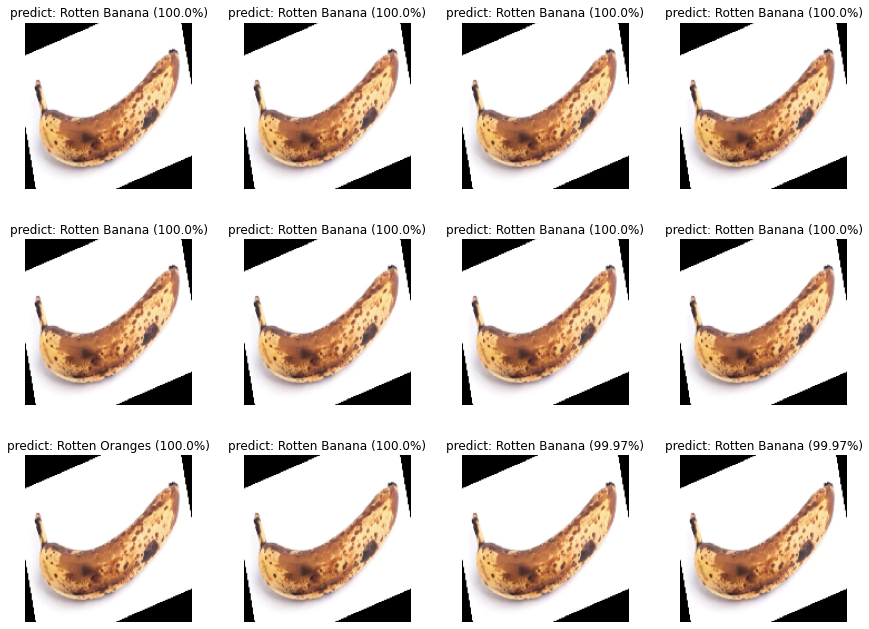

In [89]:
images = np.vstack([test_image])
classes = cnn_model.predict(images, batch_size=10)
max = np.amax(classes[0])

if np.where(classes[0] == max)[0] == 0:
    image_conf.append(max)
    predict_result.append('Fresh Banana')
elif np.where(classes[0] == max)[0] == 1:
    image_conf.append(max)
    predict_result.append('Fresh Oranges')
elif np.where(classes[0] == max)[0] == 2:
    image_conf.append(max)
    predict_result.append('Rotten Oranges')
elif np.where(classes[0] == max)[0] == 3:
    image_conf.append(max)
    predict_result.append('Rotten Banana')

plt.figure(figsize=(15, 15))
for n in range(len(image_name)):
  plt.subplot((len(image_name)/4)+1, 4, n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image.load_img(path, color_mode="rgb", target_size=(150, 150), interpolation="nearest"))
  title = f"predict: {predict_result[n]} ({round(float(image_conf[n])*100, 2)}%)"
  plt.title(title, color='black')
  plt.axis('off')
plt.show()